# Components

```{glue:figure} NTR_components_stds
:scale: 50%
:align: right
```

In this notebook we'll explore the various contributions to high and low water levels. At the moment this is exploratory - we are using this to take broad stroke looks. We'll do this by breaking down the time series of hourly water levels at a tide gauge into different frequency bands, with the idea that certain processes fall within these timescales. For example, we know that ENSO timescales are roughly 4-7 years. We know that PDO timescales are closer to 20 years, and the timescale of mesoscale eddies the Hawaiian Island archipelago are 3 - 6 months. It's important to keep in mind that in this analysis we are not directly relating any of these processes to the observed sea levels at the tide gauges, but rather we are looking at _variability on similar timescales_. 

Thus, we're breaking sea level down into:

$\eta = \eta_{tide} + \eta_{t_N} + \eta_{NTR}$

where

$\eta_{NTR} = \eta_{ID} + \eta_{D} + \eta_{S} + \eta_{ItA} + \eta_{InA} + \eta_{W} + \eta_{HF}$

Note that $\eta_{tide}$ here is accounting for the nodal cycle modulation, and thus it is absent from the non-tidal residuals.

<!-- # make a dictionary of the timescales and the processes
timeframes = {'Interdecadal': '>30 yr cycles', 
              'Decadal': 'e.g. PDO, 8-30 yr', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-8 yr', 
              'Intraannual': 'e.g. Mesoscale eddies', 
              'Weekly': '1 week - 2 months', 
              'Storms': '& other short-term variability',
              'Nodal': '18.6 yr tidal modulation'} -->


```{caution}
THIS IS VERY MUCH a work in progress. Please do not consider any of this final.
```

## Setup

In [258]:
%run setup.ipynb
%run plotting_functions.ipynb
%run tseries_functions.py
from tide_functions import calculate_ntr

## Obtain the Non-tidal Residual (NTR)

First we'll estimate the astronomical tides at this location using the selected epoch.

In [259]:
ds = xr.open_dataset(data_dir / 'rsl_hawaii.nc')

# get the ntr for each station
calculate_ntr(ds)

Already processed 8 files:
[50, 52, 57, 552, 58, 59, 61, 60]
Working on station 14: French Frigate
Not enough data for station French Frigate
Working on station 547: Barbers Point, HI
Not enough data for station Barbers Point, HI
Working on station 548: Kaumalapau, HI
Not enough data for station Kaumalapau, HI


In [260]:
# load ntr data
station = 58
print('Doing station', station)
station_name = ds.station_name.sel(record_id=station).item()
print('Station name:', station_name)
mhhw = ds.MHHW.sel(record_id=station).item()
mllw = ds.MLLW.sel(record_id=station).item()
ntrpath = f'ntr_data/ntr_{station:03d}.csv'


ntr_data = pd.read_csv(Path(data_dir / ntrpath), parse_dates=['time'])

#inspect it, does it look sane?
ntr_data

Doing station 58
Station name: Nawiliwili


,time,ntr,sea_level,tide,nodal,ntr_withNodal
0,1954-12-01 14:00:00,40.545226,1066.0,1025.454774,7.143244,47.688470
1,1954-12-01 15:00:00,21.338728,1127.0,1105.661272,4.775734,26.114462
2,1954-12-01 16:00:00,17.087831,1188.0,1170.912169,1.259160,18.346992
3,1954-12-01 17:00:00,37.933924,1249.0,1211.066076,-3.747699,34.186225
4,1954-12-01 18:00:00,30.380276,1249.0,1218.619724,-10.319180,20.061096
...,...,...,...,...,...,...
615101,2025-01-31 19:00:00,172.735602,1153.0,980.264398,20.091015,192.826618
615102,2025-01-31 20:00:00,167.102445,1023.0,855.897555,16.432552,183.534997
615103,2025-01-31 21:00:00,161.394009,933.0,771.605991,10.877304,172.271313
615104,2025-01-31 22:00:00,147.816317,889.0,741.183683,4.403589,152.219906


### Plot and Inspect
We're looking at the NTR with and without the nodal modulation removed.

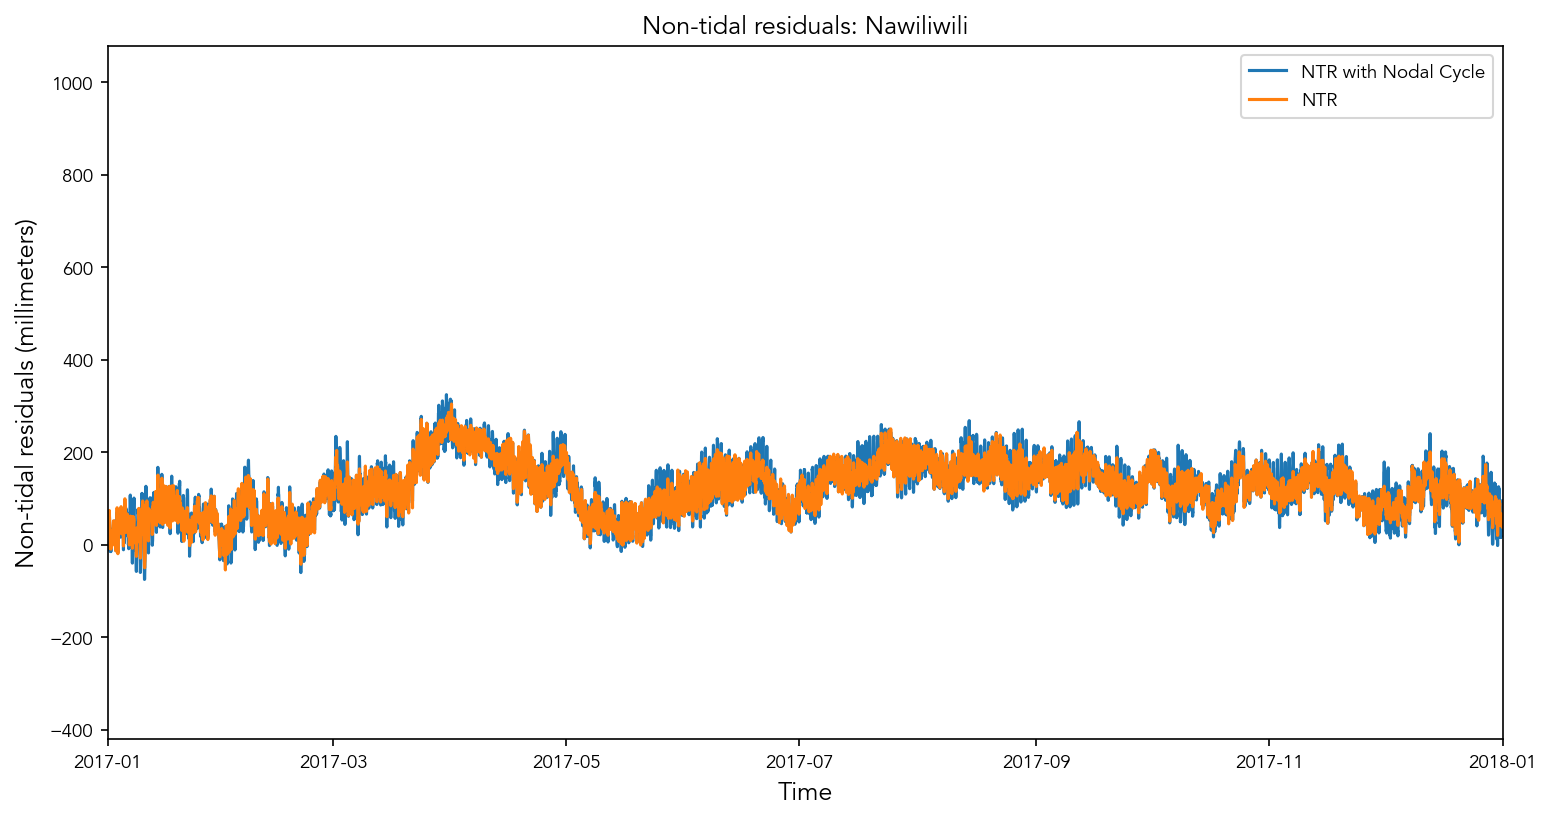

In [261]:
#plot time series
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['ntr_withNodal'], label='NTR with Nodal Cycle')
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')

# plt.plot(ntr_data['time'], ntr_data['nodal'], label='Nodal Cycle')

# add title
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2000-2005
plt.xlim([np.datetime64('2017-01-01'), np.datetime64('2018-01-01')])
plt.legend()


### Let's examine the Nodal modulation a bit more
As noted by others studying the Honolulu tide gauge (e.g. Thompson et al), the modulation of the nodal cycle on the 99th percentile water levels can affect high sea levels by up to 5cm. In low-lying areas this contribution can be significant. Here, we'll simulate this effect by taking the upper envelope of the monthly max of the nodal modulation. 

In [262]:
# # Let's try treating the nodal cycle  in terms of its envelope - we'll use the Hilbert transform for this
import scipy.signal as signal

nodal = ntr_data['nodal'].copy()
# set index to time
nodal.index = ntr_data['time']
# resample nodal to monthly on the max
nodal_upper_envelope = nodal.resample('ME').max()
# 
# # Obtain the upper envelope of the nodal cycle using the amplitude of the Hilbert transform
analytic_signal = signal.hilbert(nodal_upper_envelope)
envelope = np.abs(analytic_signal)

envelope = pd.Series(envelope, index=nodal_upper_envelope.index)

# Shift the envelope 

# resample the envelope back to ntr_data time index
# envelope = envelope.reindex(ntr_data['time'], method='ffill')
# envelope = envelope.shift(periods=1, freq='15d')  # shift by 12 hours to align with the data

# interpolate the envelope to the ntr_data time index
envelope = envelope.reindex(ntr_data['time']).interpolate(method='linear')



(10957.0, 19783.0)

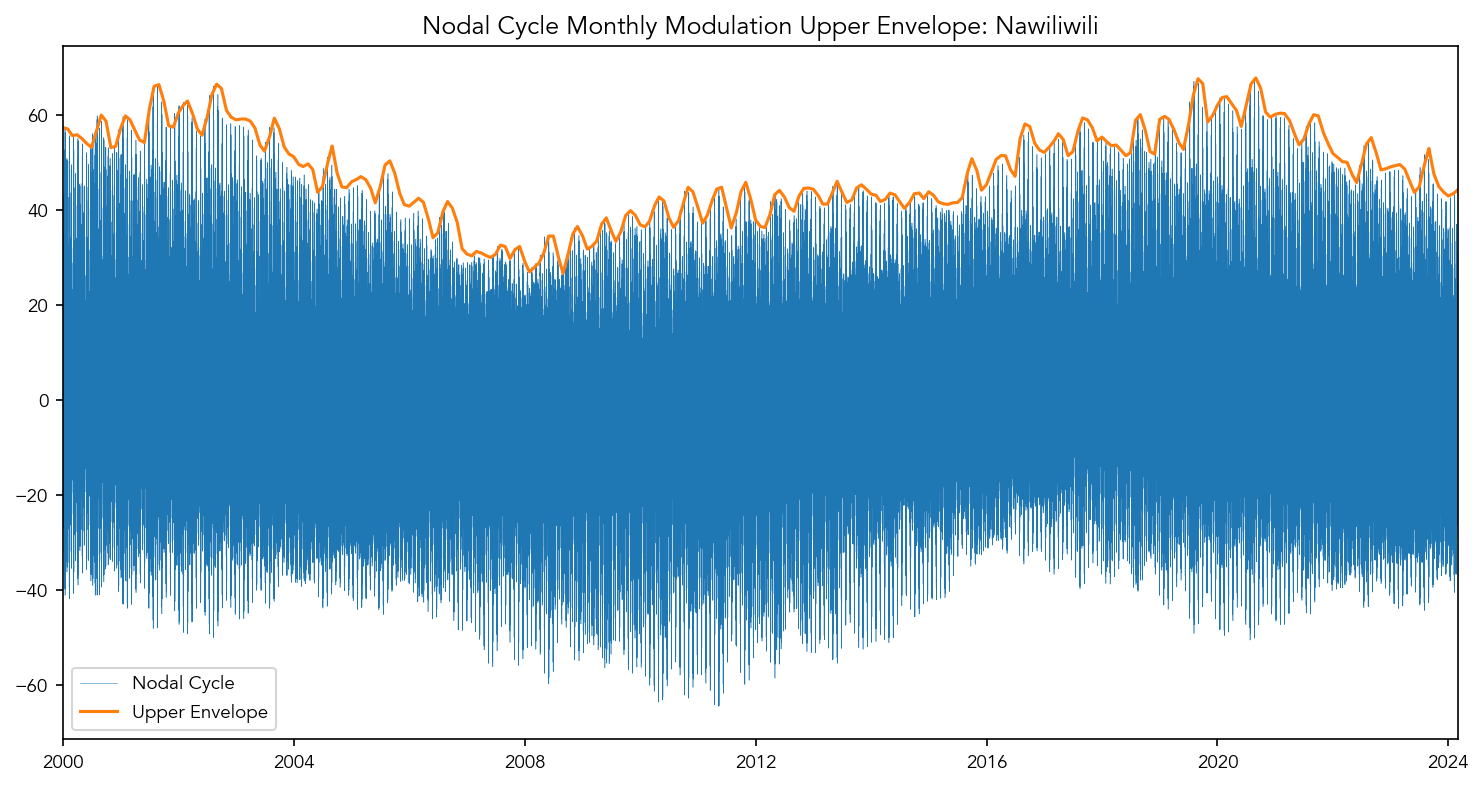

In [263]:
#plot the nodal signal and the envelope
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['nodal'], label='Nodal Cycle',linewidth=0.25)
plt.plot(envelope.index, envelope, label='Upper Envelope')
plt.title('Nodal Cycle Monthly Modulation Upper Envelope: ' + station_name)

plt.legend()
#set x-axis to 2017-2018
plt.xlim([np.datetime64('2000-01-01'), np.datetime64('2024-03-01')])

In [264]:
# ntr_data['time'] = pd.to_datetime(ntr_data['time'])
# ntr_data = ntr_data.set_index('time')
#make subset dataframe of ntr data with just ntr and time
sea_level_data = ntr_data[['ntr','time']].copy()
# sea_level_data['time'] = ntr_data['time']
ntr_data_mags,ntr_trend_series,ntr_trend_rates = process_trend_with_nan(sea_level_data)
# sea_level_data
ntr_data['ntr_detrended'] = ntr_data['ntr'] - ntr_trend_series['ntr']

Text(0, 0.5, 'Non-tidal residuals (millimeters)')

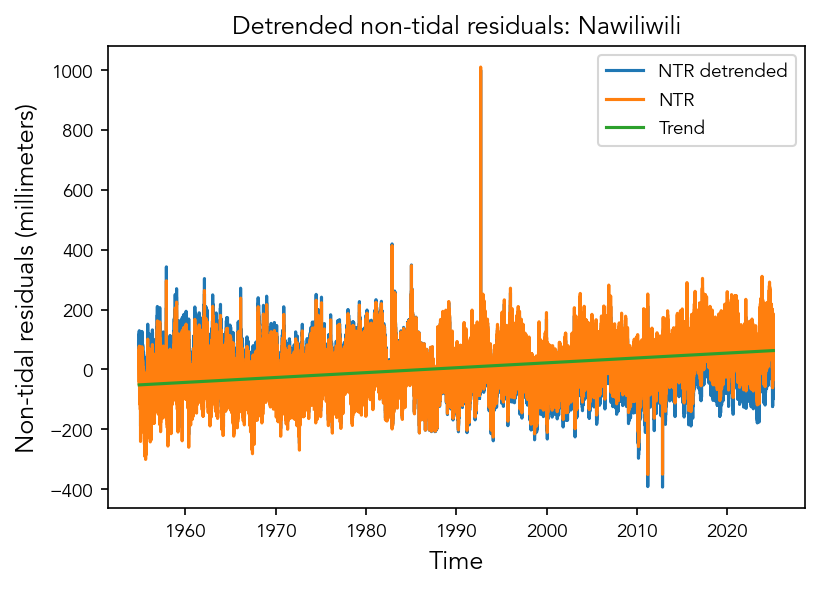

In [265]:
plt.plot(ntr_data['time'], ntr_data['ntr_detrended'], label='NTR detrended')
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_trend_series['ntr'], label='Trend')
plt.legend()

# add title
plt.title('Detrended non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2001 Jan to Feb
# plt.xlim([np.datetime64('2017-10-01'), np.datetime64('2017-10-02')])

# set y-axis to -0.1 to 0.1
# plt.ylim([0,200])

In [266]:
# Now start to filter for each frequency band we want

# make time_diffs in hours
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)
widthSeasonal = 1/365.25/10; #1 cycle per decade



In [267]:
# # print the length of each segment and the start and end times
# for i in range(len(segments)):
#     print(f'Segment {i}: {len(segments[i])} points, {segments[i].time.iloc[0]} to {segments[i].time.iloc[-1]}')

In [268]:
# filtered_segments = filter_segments(segments,value_column='ntr_detrended',freq_cutoff=1/(365.25*20),order=4)

```{caution}
The timescales probably need some refinement. For example: mesoscale processes. Higher the latitude the longer the period!!
```
From Chen, S., and B. Qiu (2010), Mesoscale eddies northeast of the Hawaiian archipelago from satellite altimeter observations, J. Geophys. Res., 115, C03016, doi:10.1029/2009JC005698


"We define dominant periods of the mesoscale eddy activity by locating the periods at which the spectral peaks within the mesoscale range of 90–180 days. This definition is crude yet robust for the subregions with sharp spectral peaks like the 24°N–27°N, 160°W–155°W one (130 days) and the 18°N–21°N, 170°W–165°W one (90 days), but is also applicable to other subregions. In the lee of the island of Hawaii, 90 day oscillations dominate the mesoscale eddy activity. In the subregions between 24°N and 30°N, a 130 day peak often prevails, but in the 30°N–33°N band, a weak 180 day peak emerges. The pattern is that the higher the latitude, the longer the dominant period."

Also:
Firing, Y. L., and M. A. Merrifield (2004), Extreme sea level events at Hawaii: Influence of mesoscale eddies, Geophys. Res. Lett., 31, L24306, doi:10.1029/2004GL021539.

In [269]:
# Define timescales (in days)
annual = 365.25
semiannual = 365.25/2
qtrannual = 365.25/4
weekly = 7
bimonthly = 2*365.25/12
decadal = 8*365.25
interdecadal = 30*365.25


# make a dictionary of the timescales and the processes
timeframes = {'Interdecadal': '>30 yr cycles', 
              'Decadal': 'e.g. PDO, 8-30 yr', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-8 yr', 
              'Intraannual': 'e.g. Mesoscale eddies', 
              'Weekly': '1 week - 2 months', 
              'Storms & HF': '& other short-term variability',
              'Nodal': '18.6 yr tidal modulation'}

# get frequency of annual cycle
# annual_freq = 1/annual

In [270]:

def filter_ntr(ntr_data):
    ntr_noAnnual, ntr_Annual = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs,1/annual , width=widthSeasonal)
    ntr_noSemiAnnual, ntr_SemiAnnual = filter_known_frequency_components(ntr_noAnnual, time_diffs, 1/semiannual, width=widthSeasonal)
    ntr_noQtrAnnual, ntr_QtrAnnual = filter_known_frequency_components(ntr_noSemiAnnual, time_diffs, 1/qtrannual, width=widthSeasonal)
    ntr_Seasonal = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual

    #interdecadal
    ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_noQtrAnnual, time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)

    #decadal
    ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/decadal, order=3) 

    #interannual
    ntr_interannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/annual, order=4)

    # intraannual
    ntr_intraannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/bimonthly, order=5)

    # Remove high frequencies (weekly to hourly)
    # ntr_weekly is timescales longer than 7 days but less than 1 month
    ntr_weekly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/weekly, order=5)

    # make dataframe of filtered data
    ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr_detrended'], 
                             'sea_level': ntr_data['sea_level'],
                             'tide': ntr_data['tide'],
                             'Nodal': ntr_data['nodal'],
                             'Interdecadal': ntr_interdecadal, 
                             'Decadal': ntr_decadal, 
                             'Interannual': ntr_interannual, 
                             'Seasonal': ntr_Seasonal, 
                             'Intraannual': ntr_intraannual, 
                             'Weekly': ntr_weekly, 
                             'Storms & HF': ntr_highFreq})


    return ntr_filtered


In [271]:

ntr_filtered = filter_ntr(ntr_data)

# get std of each component
ntr_component_stds = ntr_filtered.std()

# remove time from ntr)component_stds
ntr_component_stds = ntr_component_stds.drop('time')

# look at filtered components of nodal cycle only
nodal_data = ntr_data.copy()
nodal_data.index = ntr_data['time']
envelope_demeaned = envelope - np.nanmean(envelope)
envelope_demeaned.index = nodal_data.index
nodal_data['ntr_detrended'] = envelope_demeaned
nodal_filtered = filter_ntr(nodal_data)

#rename "ntr" in nodal_filtered to "nodal upper envelope"
nodal_filtered = nodal_filtered.rename(columns={'ntr': 'nodal envelope'})

nodal_component_std = nodal_filtered.std() 
nodal_component_std = nodal_component_std.drop('time')



Filled 1 % of data with noise (std = 64.2581).
Filled 1 % of data with noise (std = 62.7277).
Filled 1 % of data with noise (std = 62.1870).
Filled 1 % of data with noise (std = 61.7318).
Filled 0 % of data with noise (std = 9.0996).
Filled 0 % of data with noise (std = 9.0442).
Filled 0 % of data with noise (std = 8.8886).
Filled 0 % of data with noise (std = 8.8879).


In [272]:
ntr_filtered

,time,ntr,sea_level,tide,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
0,1954-12-01 14:00:00,92.042649,1066.0,1025.454774,7.143244,39.729442,-10.721414,43.547131,14.823418,15.287073,-3.011646,-7.611356
1,1954-12-01 15:00:00,72.835965,1127.0,1105.661272,4.775734,39.728927,-10.723969,43.520897,14.825165,15.205199,-4.020715,-25.699538
2,1954-12-01 16:00:00,68.584881,1188.0,1170.912169,1.259160,39.728412,-10.726524,43.494656,14.826848,15.123452,-5.029193,-28.832769
3,1954-12-01 17:00:00,89.430788,1249.0,1211.066076,-3.747699,39.727896,-10.729079,43.468408,14.828469,15.041834,-6.036575,-6.870165
4,1954-12-01 18:00:00,81.876954,1249.0,1218.619724,-10.319180,39.727381,-10.731634,43.442154,14.830026,14.960345,-7.042357,-13.308962
...,...,...,...,...,...,...,...,...,...,...,...,...
615101,2025-01-31 19:00:00,109.631004,1153.0,980.264398,20.091015,4.558699,0.478973,62.285290,14.813752,-84.777663,-5.728576,118.000528
615102,2025-01-31 20:00:00,103.997660,1023.0,855.897555,16.432552,4.558699,0.478973,62.285290,14.815810,-84.777663,-5.727507,112.364058
615103,2025-01-31 21:00:00,98.289038,933.0,771.605991,10.877304,4.558699,0.478973,62.285290,14.817805,-84.777663,-5.726637,106.652571
615104,2025-01-31 22:00:00,84.711160,889.0,741.183683,4.403589,4.558699,0.478973,62.285290,14.819739,-84.777663,-5.725938,93.072060


In [273]:
ntr_component_stds

ntr              64.258122
sea_level       189.229716
tide             174.15518
Nodal            19.573692
Interdecadal     10.965552
Decadal           17.46959
Interannual      31.097804
Seasonal         14.587832
Intraannual      31.699024
Weekly            24.49236
Storms & HF       23.55852
dtype: object

Text(0.5, 1.0, 'Correlation Matrix\n of upper nodal envelope components')

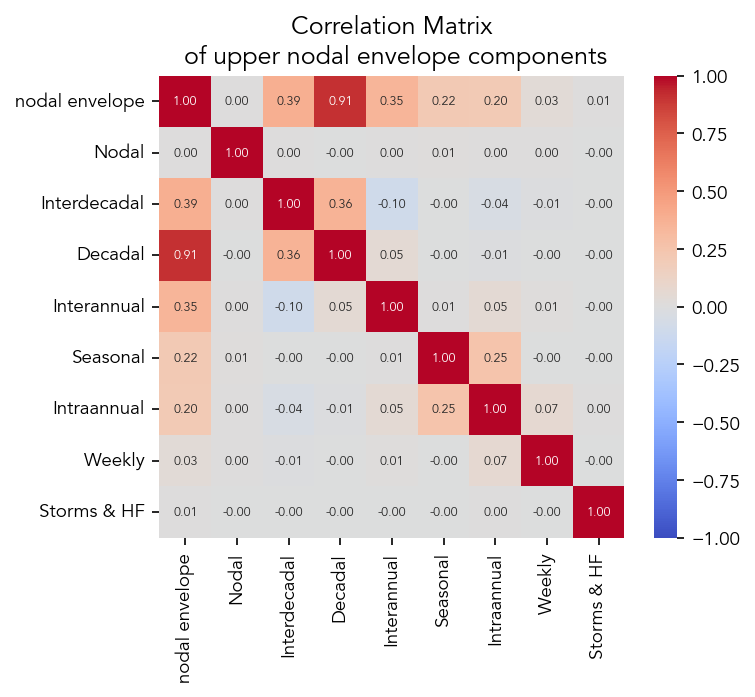

In [274]:
nodal_component_std
nodal_corr = nodal_filtered.drop(['time','sea_level','tide'], axis=1).corr()
#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(nodal_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation Matrix\n of upper nodal envelope components')

Text(0, 0.5, 'Sum of components')

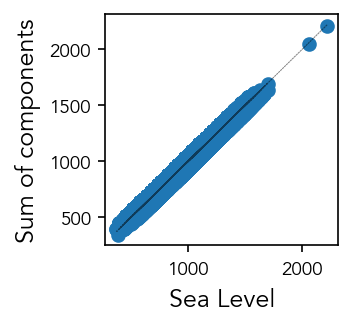

In [275]:
#plot ntr, then plot summed components
plt.figure(figsize=(2, 2))
ntr_sum = (ntr_filtered['Interdecadal']+
         ntr_filtered['Decadal']+
         ntr_filtered['Interannual']+
         ntr_filtered['Seasonal']+
         ntr_filtered['Intraannual']+
         ntr_filtered['Weekly']+
         ntr_filtered['Storms & HF'] +
         ntr_filtered['tide'])
#make a dotted 1:1 line
plt.plot(ntr_filtered['sea_level'], ntr_filtered['sea_level'], 'k:', label='1:1 line',linewidth=0.5,alpha=0.5)
plt.scatter(ntr_filtered['sea_level'], ntr_sum)

plt.xlabel('Sea Level')
plt.ylabel('Sum of components')


In [276]:
#export data
# ntr_filtered.to_csv('data/ntr_filtered_059b.csv', index=False)

Text(0.5, 1.0, 'Correlation between each component')

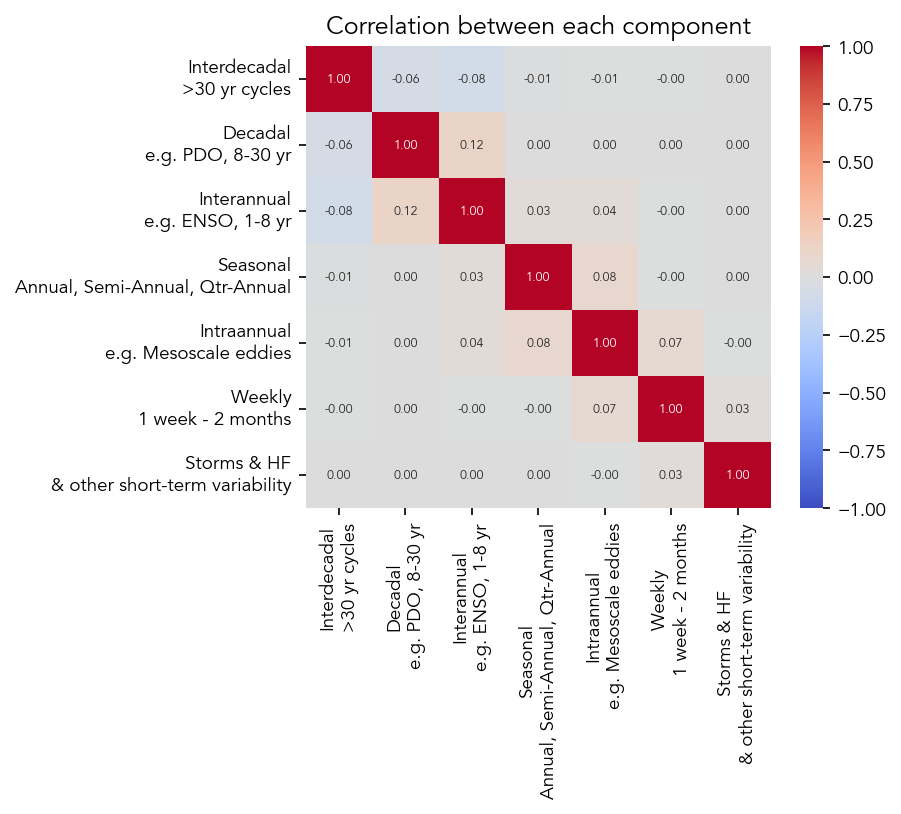

In [277]:
import seaborn as sns
import matplotlib.pyplot as plt

#make a heatmap plot of correlation between each component
ntr_corr = ntr_filtered.drop(['time','sea_level','tide','ntr','Nodal'], axis=1).corr()

# add description to each component in ntr correlation matrix
ntr_corr.columns = [col + '\n' + timeframes[col] for col in ntr_corr.columns]
ntr_corr.index = [col + '\n' + timeframes[col] for col in ntr_corr.index]
#exclude time,sea_level, and tide from the correlation matrix

#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(ntr_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation between each component')



Note there is correlation between some of these timeseries, likely due to the filtering process employed in this notebook. 

In [278]:
# get the cumulative sum of the components
ntr_cumsum = ntr_filtered[['Interdecadal', 'Decadal', 'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF']].cumsum(axis=1)
ntr_cumsum_stds = ntr_cumsum.std()
ntr_cumsum_stds
# make a plot of ntr_filtered and ntr_cumsum
# fig, ax = plt.subplots(figsize=(12, 6))
# ntr_filtered.plot(x='time', y=['ntr'], ax=ax, color=['black'], linewidth=1)
# ntr_filtered_sums.plot(x='time', y=['Nodal'] +['> 20 years'], ax=ax, color='yellow',linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years'], ax=ax, linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week'], ax=ax, linewidth=1, linestyle='--')


Interdecadal    10.965552
Decadal         20.104456
Interannual     37.967813
Seasonal        41.119568
Intraannual     53.300113
Weekly          59.486249
Storms & HF     64.233300
dtype: float64

In [279]:
ntr_filtered.keys()

Index(['time', 'ntr', 'sea_level', 'tide', 'Nodal', 'Interdecadal', 'Decadal',
       'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF'],
      dtype='object')

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


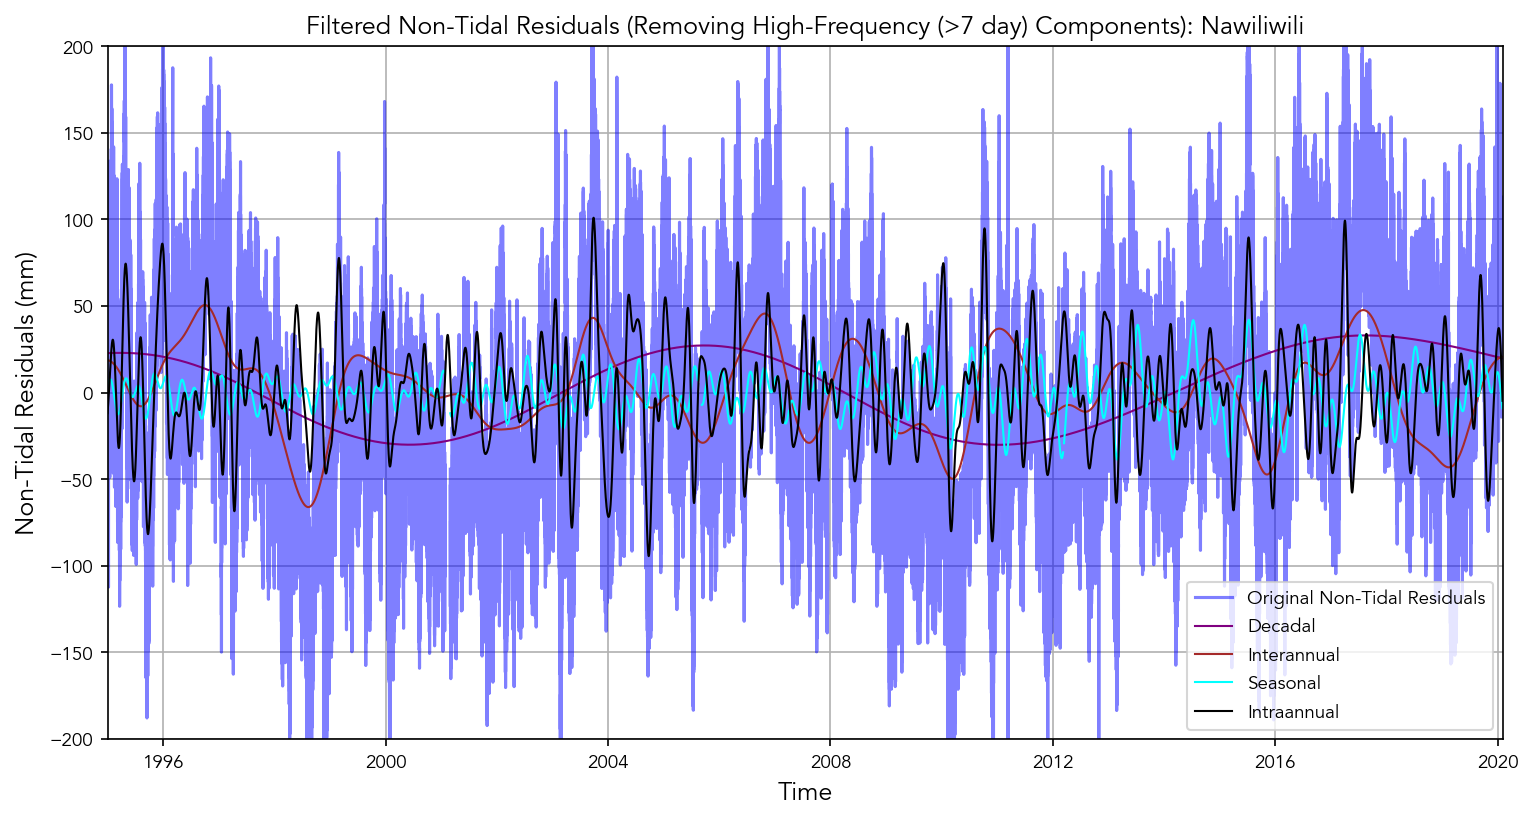

In [280]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

# plt.plot(ntr_filtered['time'], ntr_filtered['Nodal']+ntr_filtered['nodal_utide'], label='Nodal', color='green', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Decadal'], label='Decadal', color='purple', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Interannual'], label='Interannual', color='brown', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Intraannual'], label='Intraannual', color='black', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 2 month'], label='1 week - 2 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (mm)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
plt.xlim(pd.Timestamp('1995-01-01'), pd.Timestamp('2020-02-01'))
plt.ylim(-200, 200)
plt.show()

In [281]:
ntr_component_stds

ntr              64.258122
sea_level       189.229716
tide             174.15518
Nodal            19.573692
Interdecadal     10.965552
Decadal           17.46959
Interannual      31.097804
Seasonal         14.587832
Intraannual      31.699024
Weekly            24.49236
Storms & HF       23.55852
dtype: object

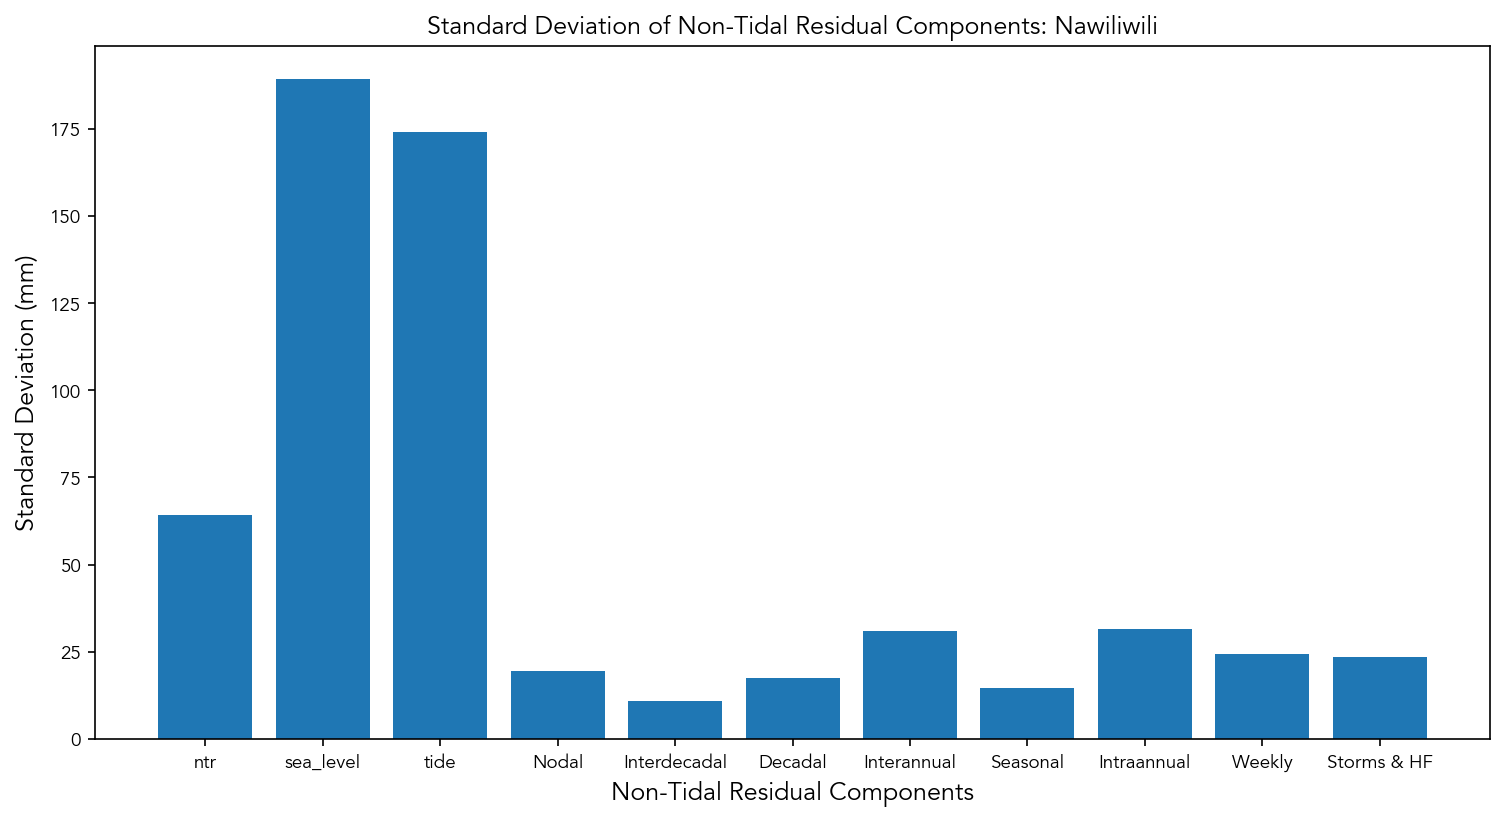

In [282]:
#make a bar plot of the std of each component
import textwrap

fig, ax = plt.subplots(figsize=(12, 6))
component_names = ntr_component_stds.index
component_stds = ntr_component_stds
ax.bar(component_names, component_stds)
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in component_names]
plt.xticks(range(len(component_names)), wrapped_labels)
# plt.xticks(rotation=45)
ax.set_xlabel('Non-Tidal Residual Components')
ax.set_ylabel('Standard Deviation (mm)')
ax.set_title('Standard Deviation of Non-Tidal Residual Components: ' + station_name)


plt.show()

In [283]:
component_stds

ntr              64.258122
sea_level       189.229716
tide             174.15518
Nodal            19.573692
Interdecadal     10.965552
Decadal           17.46959
Interannual      31.097804
Seasonal         14.587832
Intraannual      31.699024
Weekly            24.49236
Storms & HF       23.55852
dtype: object

## Plot components
Make a bar plot of average contributions to water levels.

/var/folders/9w/vpws17h965v7n60fmhp97k5r0000gq/T/ipykernel_17153/3394451137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))


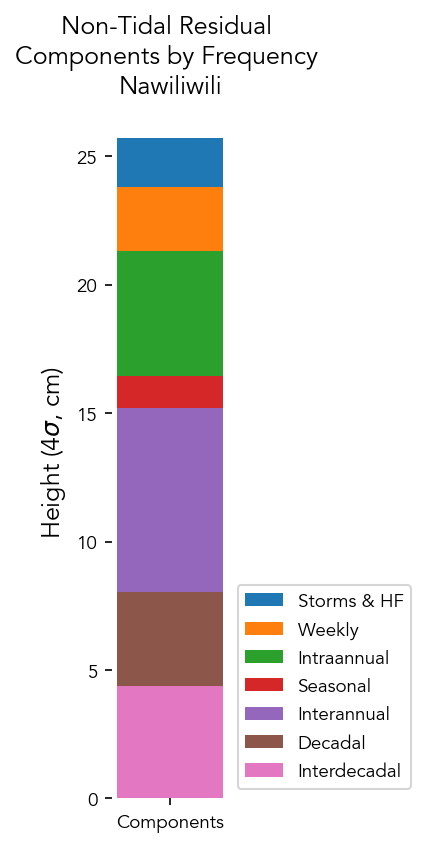

In [284]:
# Create figure
fig, ax = plt.subplots(figsize=(1, 6))

# Plot stacked bars
bottom = 0
for i in range(len(ntr_cumsum_stds.index)-1, -1, -1):
    ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))

# ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# Labels and title
ax.set_ylabel('Height (4$\sigma$, cm)')
ax.set_title('Non-Tidal Residual \nComponents by Frequency \n' + station_name)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# no box
for spine in ax.spines.values():
    spine.set_visible(False)

figName = 'NTR_components_stds' + station_name
glue('NTR_components_stds',fig,display=False)


It's important to note that in the plot above, we're looking at the $4\sigma$, which is akin to 'significant wave height.' Nor do we consider each $\sigma$ independently in this plot, but instead we compute the standard deviation of the combined signals, as we work our way up to higher and higher frequencies. For example, the purple line above shows the contributions of any cycles that occur on timescales longer than 1 year. Each individual componenent has its own standard deviation but none are truly indepedent signals (due to the filtering mechanism here) and therefore the variances cannot be directly added together to represent the total variances of the whole signal. (See the correlation plot above.)

In [285]:
# get dates of extreme events
station_name_1st = station_name.split(',')[0]
top10tableName = 'SL_top_10_table_' + station_name_1st + '.csv'

#temporarily set the output_dir to ../output
output_dir = Path('../output')
extremes_csv = Path(output_dir, top10tableName)
extremes = pd.read_csv(extremes_csv)

In [286]:
extremes

,Rank,Highest,Highest Date,Highest ONI Mode,Lowest,Lowest Date,Lowest ONI Mode,Zone,ONI max,ONI min
0,1,0.457,2023-10-30 15:00,El Nino,-0.856,2011-03-12 00:00,La Nina,GMT,1.92,-0.93
1,2,0.407,2020-12-15 15:00,La Nina,-0.806,2010-02-28 07:00,El Nino,GMT,-1.19,1.22
2,3,0.405,2017-07-23 02:00,Neutral,-0.798,2010-03-05 22:00,El Nino,GMT,0.14,0.84
3,4,0.402,2021-12-05 15:00,La Nina,-0.773,2000-01-21 07:00,La Nina,GMT,-0.98,-1.66
4,5,0.394,2023-08-30 01:00,El Nino,-0.769,2002-02-27 07:00,Neutral,GMT,1.32,0.03
5,6,0.388,2016-06-05 02:00,Neutral,-0.765,1993-11-15 07:00,Neutral,GMT,-0.07,0.04
6,7,0.388,2017-08-21 01:00,Neutral,-0.765,1994-02-06 03:00,Neutral,GMT,-0.11,0.07
7,8,0.385,2006-11-06 14:00,El Nino,-0.761,1993-11-12 05:00,Neutral,GMT,0.94,0.04
8,9,0.385,2015-07-03 03:00,El Nino,-0.761,1993-12-14 07:00,Neutral,GMT,1.52,0.06
9,10,0.383,2019-12-25 14:00,Neutral,-0.761,1994-02-03 00:00,Neutral,GMT,0.55,0.07


In [287]:
extremes_highest = extremes['Highest Date'].values
extremes_lowest = extremes['Lowest Date'].values

extremes_highest = pd.to_datetime(extremes_highest)
extremes_lowest = pd.to_datetime(extremes_lowest)

extremes_highest

DatetimeIndex(['2023-10-30 15:00:00', '2020-12-15 15:00:00',
               '2017-07-23 02:00:00', '2021-12-05 15:00:00',
               '2023-08-30 01:00:00', '2016-06-05 02:00:00',
               '2017-08-21 01:00:00', '2006-11-06 14:00:00',
               '2015-07-03 03:00:00', '2019-12-25 14:00:00'],
              dtype='datetime64[ns]', freq=None)

In [288]:
# extract these dates from the ntr filtered data
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_low = ntr_filtered[ntr_filtered['time'].isin(extremes_lowest)].copy()

# get tide data for these dates from ntr_data
tide_data = ntr_data['tide']
ntr_data_extremes_high = ntr_data[ntr_data['time'].isin(extremes_highest)].copy()
ntr_data_extremes_low = ntr_data[ntr_data['time'].isin(extremes_lowest)].copy()

# add tide and sea level data to ntr_filtered_extremes_high
ntr_filtered_extremes_high.loc[:, 'tide'] = ntr_data_extremes_high['tide'].values
ntr_filtered_extremes_high.loc[:, 'sea_level'] = ntr_data_extremes_high['sea_level'].values
ntr_filtered_extremes_low.loc[:, 'tide'] = ntr_data_extremes_low['tide'].values
ntr_filtered_extremes_low.loc[:, 'sea_level'] = ntr_data_extremes_low['sea_level'].values


# arrange columns
column_order = ['time', 'ntr', 'sea_level', 'tide', 'Nodal', 'Interdecadal', 'Decadal', 'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF']
ntr_filtered_extremes_high = ntr_filtered_extremes_high[column_order]
ntr_filtered_extremes_low = ntr_filtered_extremes_low[column_order]
ntr_filtered_extremes_high

#export data
ntr_filtered_extremes_high.to_csv('../data/ntr_filtered_extremes_high_059b.csv', index=False)
ntr_filtered_extremes_low.to_csv('../data/ntr_filtered_extremes_low_059b.csv', index=False)


In [289]:
ntr_filtered_extremes_high

,time,ntr,sea_level,tide,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
455232,2006-11-06 14:00:00,136.610908,1625.0,1455.070350,25.528750,-12.400988,21.088852,45.366322,11.170454,45.784079,0.124725,25.477464
531085,2015-07-03 03:00:00,198.244658,1625.0,1379.304114,-21.316565,0.320386,18.415667,-19.213187,39.989923,85.476650,48.280288,24.974931
539196,2016-06-05 02:00:00,185.793316,1628.0,1393.244261,-24.935242,1.436684,28.061142,14.598458,13.740671,37.404583,78.865315,11.686464
549108,2017-07-23 02:00:00,151.505590,1645.0,1442.685241,-11.511166,2.561167,32.973843,47.536543,28.923121,-2.584868,34.865320,7.230465
549803,2017-08-21 01:00:00,169.228839,1628.0,1407.832504,-4.895323,2.629506,32.988244,47.098344,3.913213,33.864833,9.144685,39.590014
570360,2019-12-25 14:00:00,171.411494,1623.0,1396.819788,-7.592777,4.040163,20.605734,19.015946,11.662970,28.365775,41.806064,45.914843
578905,2020-12-15 15:00:00,137.244679,1647.0,1453.394550,2.825935,4.321110,12.718594,35.040893,14.105948,16.747863,22.520538,31.789734
587425,2021-12-05 15:00:00,95.923678,1642.0,1488.128154,7.315507,4.472695,5.858272,-22.980805,16.125503,-16.639039,51.334881,57.752173
602603,2023-08-30 01:00:00,113.008153,1634.0,1460.215802,34.228436,4.554913,0.663288,35.448839,13.745111,30.324105,11.467176,16.804721
604081,2023-10-30 15:00:00,216.554386,1697.0,1419.394197,15.312514,4.556421,0.577995,50.477993,15.230072,70.321685,30.598336,44.791883


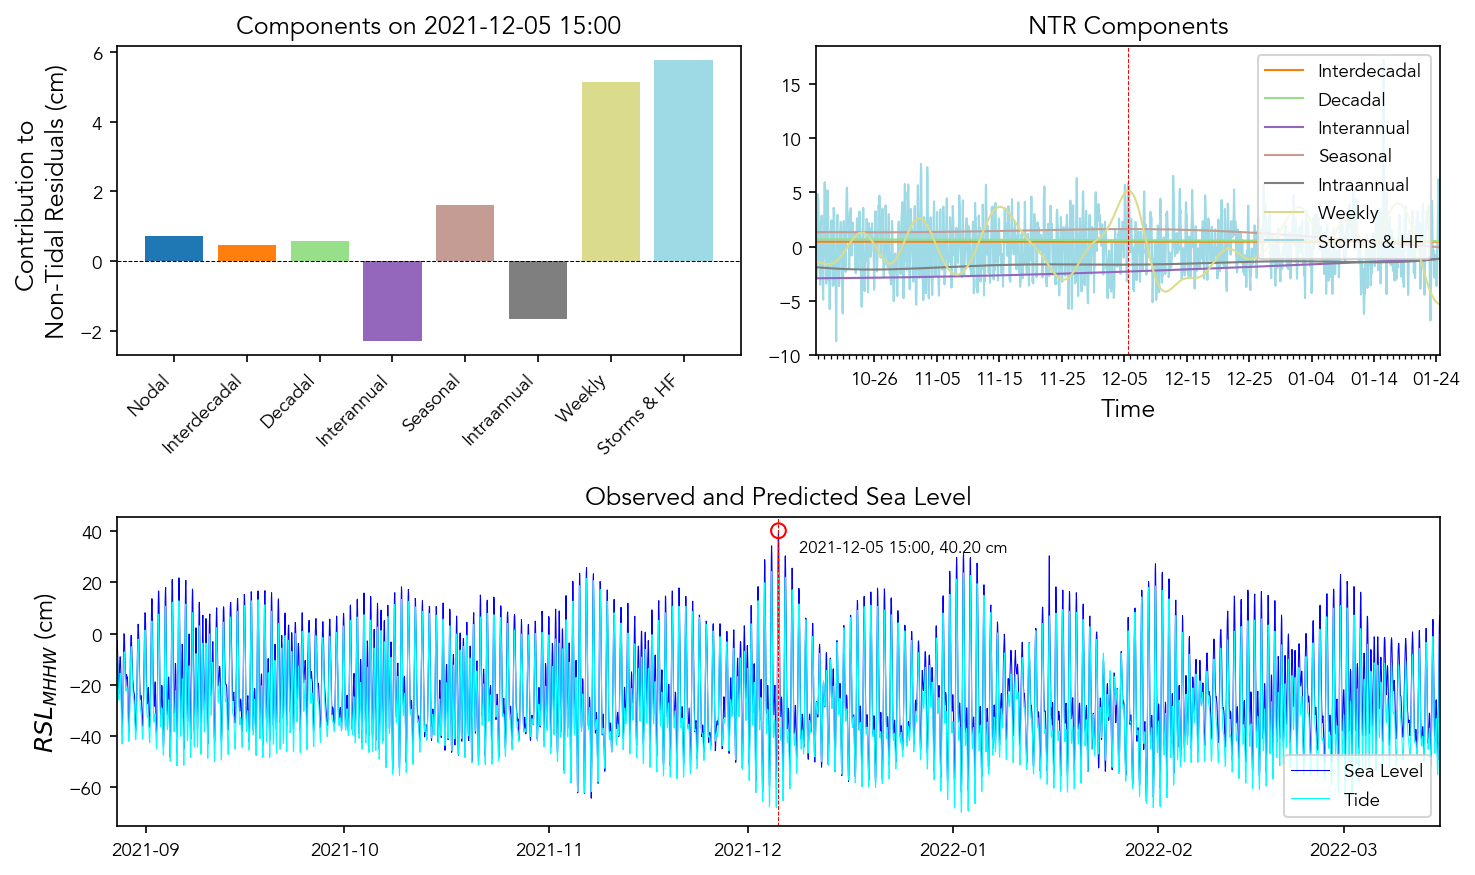

In [292]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

idx = 7

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
dates_to_plot = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(dates_to_plot).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == dates_to_plot]

# Extract the components
components = column_order[4:]
component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component


fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# assign 1 color to each component. There are XX components, so we need XX colors
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))


### --- TOP LEFT PLOT: Bar Chart --- ###
ax = axes[0, 0]  # First row, first column
ax.bar(x_positions, 0.1*component_values, alpha=1, color=colors)
ax.set_xticks(x_positions)
ax.set_xticklabels(components, rotation=45, ha='right')

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Resize subplot width
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])  # Shrink width to 75%

### --- TOP RIGHT PLOT: NTR & Weekly Trends --- ###
ax = axes[0, 1]  # First row, second column

# Filter data to ±10 days around `dates_to_plot`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=dates_to_plot - plusTime, end=dates_to_plot + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot NTR and Weekly trends
# ax.plot(data_on_date.index, 0.1*data_on_date['ntr'], label='NTR', color='black', linewidth=0.5)
for col in data_on_date.columns:
    #only do for columns that aren't tide or sea level
    if col not in ['sea_level','tide','NTR','ntr','Nodal','Storms & HF']:
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1)
    if col == 'Storms & HF': #put on the bottom
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1,zorder=0)

ax.axvline(dates_to_plot, color='red', linestyle='--', linewidth=0.5)

#ensure x-axis is readable
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('NTR Components')
ax.set_xlabel('Time')
ax.legend(loc='upper right')

### --- BOTTOM PLOT: Sea Level, Tide, and Interannual --- ###
fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 0])
ax = fig.add_subplot(2, 1, 2)

# Filter data to ±100 days around `dates_to_plot`
plusTime = pd.Timedelta('100d')
timespan = pd.date_range(start=dates_to_plot - plusTime, end=dates_to_plot + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['sea_level'] - mhhw), label='Sea Level', color='blue', linewidth=0.5)
ax.plot(data_on_date.index, 0.1*(data_on_date['tide'] - mhhw), label='Tide', color='cyan', linewidth=0.5)

ax.set_ylabel('$RSL_{MHHW}$ (cm)')

# Add legend and vertical line
ax.legend(loc='lower right')

# add circle at the date and height
ax.scatter(dates_to_plot, 0.1*(sl_extreme-mhhw), color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{date_str}, {0.1*(sl_extreme-mhhw):.2f} cm', 
             (dates_to_plot, 0.1*(sl_extreme-mhhw)), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=8)

ax.axvline(dates_to_plot, color='red', linestyle='--', linewidth=0.5)

# Set x-axis limits
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('Observed and Predicted Sea Level')

plt.tight_layout()
plt.show()


In [294]:
# We need to treat the tide component differently here to get a better comparison
# get the daily high tides
tide_data = ntr_data['tide']
tide_data.index = ntr_data['time']
tide_max_daily = tide_data.resample('D').max()

tide_max_daily_std = tide_max_daily.std()

tide_min_daily = tide_data.resample('D').min()
tide_min_daily_std = tide_min_daily.std()

In [295]:
ntr_filtered_extremes_high

,time,ntr,sea_level,tide,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
455232,2006-11-06 14:00:00,136.610908,1625.0,1455.070350,25.528750,-12.400988,21.088852,45.366322,11.170454,45.784079,0.124725,25.477464
531085,2015-07-03 03:00:00,198.244658,1625.0,1379.304114,-21.316565,0.320386,18.415667,-19.213187,39.989923,85.476650,48.280288,24.974931
539196,2016-06-05 02:00:00,185.793316,1628.0,1393.244261,-24.935242,1.436684,28.061142,14.598458,13.740671,37.404583,78.865315,11.686464
549108,2017-07-23 02:00:00,151.505590,1645.0,1442.685241,-11.511166,2.561167,32.973843,47.536543,28.923121,-2.584868,34.865320,7.230465
549803,2017-08-21 01:00:00,169.228839,1628.0,1407.832504,-4.895323,2.629506,32.988244,47.098344,3.913213,33.864833,9.144685,39.590014
570360,2019-12-25 14:00:00,171.411494,1623.0,1396.819788,-7.592777,4.040163,20.605734,19.015946,11.662970,28.365775,41.806064,45.914843
578905,2020-12-15 15:00:00,137.244679,1647.0,1453.394550,2.825935,4.321110,12.718594,35.040893,14.105948,16.747863,22.520538,31.789734
587425,2021-12-05 15:00:00,95.923678,1642.0,1488.128154,7.315507,4.472695,5.858272,-22.980805,16.125503,-16.639039,51.334881,57.752173
602603,2023-08-30 01:00:00,113.008153,1634.0,1460.215802,34.228436,4.554913,0.663288,35.448839,13.745111,30.324105,11.467176,16.804721
604081,2023-10-30 15:00:00,216.554386,1697.0,1419.394197,15.312514,4.556421,0.577995,50.477993,15.230072,70.321685,30.598336,44.791883


In [296]:

def get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std):
    """
    Get the relative amplitude of each component in the non-tidal residuals.
    
    Parameters:
    - ntr_filtered_extremes_high: pd.DataFrame, filtered non-tidal residuals for extreme high sea level events
    - ntr_component_stds: pd.Series, standard deviations of each component
    - mhhw: float, mean higher high water value
    - tide_max_daily_std: float, standard deviation of daily high tides
    
    Returns:
    - ntr_filtered_extremes_high_relative_to_std: pd.DataFrame, relative amplitudes of each component
    """
    # make a copy of the filtered extremes
    extremes_high_relative_to_std = ntr_filtered_extremes_high.copy()

    # get the relative amplitude of the tide component
    extremes_high_relative_to_std['tide'] = (ntr_filtered_extremes_high['tide'] - mhhw)/tide_max_daily_std 
    extremes_high_relative_to_std = extremes_high_relative_to_std.drop(columns=['ntr'])

    # for each component, divide by the std
    for component in extremes_high_relative_to_std.columns[3:]:
        extremes_high_relative_to_std[component] = ntr_filtered_extremes_high[component] / ntr_component_stds[component]

    return extremes_high_relative_to_std

extremes_high_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std)
extremes_low_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_low, ntr_component_stds, mllw, tide_min_daily_std)


In [297]:
def plot_component_amps(extremes_low_relative_to_std, high_or_low = 'high', station_name = ''):
    import matplotlib.colors as mcolors

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(7, 6))

    #drop the time column and turn it into the index
    extremes_high_relative_to_std_subset = extremes_low_relative_to_std.set_index('time')
    

    cmap = plt.cm.coolwarm
    colors = [(cmap(0.0)),  # Dark blue at -3
              (cmap(0.45)), # Light blue at -1
              (cmap(0.5)),  # White at 0
              (cmap(0.55)), # Light red at 1
              (cmap(1.0))]  # Dark red at 3
    positions = [-3, -1, 0, 1, 3]  # Assigning key points in data range

    # Create a new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_coolwarm", list(zip(np.linspace(0, 1, len(colors)), colors)))

    # Keep a **linear scale** but use the modified colormap
    norm = mcolors.Normalize(vmin=-3, vmax=3)

    # Plot heatmap
    if high_or_low == 'high':
        #order by highest to lowest sea level
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=False)
    if high_or_low == 'low':
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=True)

    # drop sea level column
    extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.drop(columns=['sea_level'])

    heatmap = ax.imshow(extremes_high_relative_to_std_subset.T, cmap=new_cmap, norm=norm,aspect='auto')

    # label rows and columns
    ax.set_xticks(np.arange(len(extremes_high_relative_to_std_subset)))
    ax.set_xticklabels(extremes_high_relative_to_std_subset.index.strftime('%Y-%m-%d %H:%M'),rotation=60, ha='right')
    ax.set_yticks(np.arange(len(extremes_high_relative_to_std_subset.columns)))
    ax.set_yticklabels(extremes_high_relative_to_std_subset.columns)

    # add colorbar, should be same height as heatmap
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Relative Amplitude\n (Standard Deviations)')

    # if high_or_low is high, then "Highest"
    if high_or_low == 'high':
        ax.set_title('Extreme High Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)
    elif high_or_low == 'low':
        ax.set_title('Extreme Low Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)

    return fig, ax

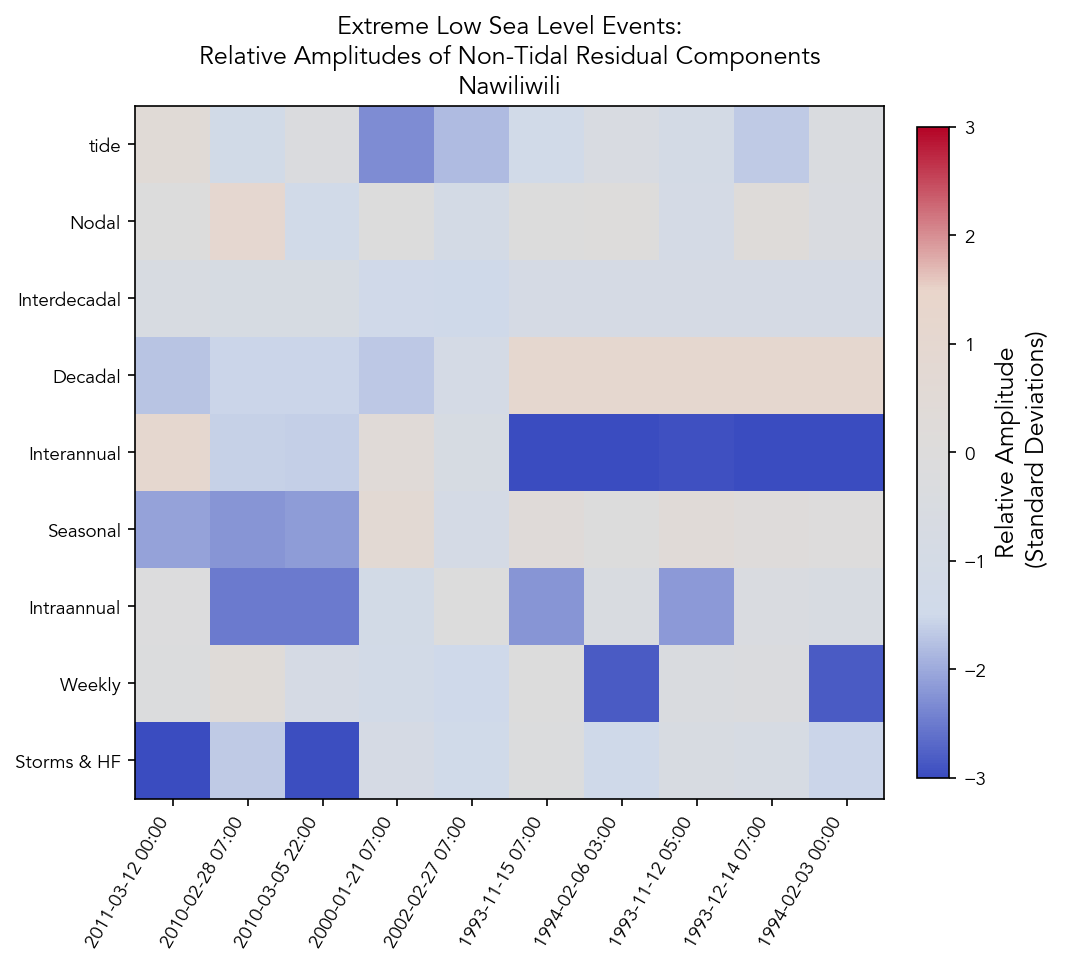

In [298]:
fig,ax = plot_component_amps(extremes_low_relative_to_std, high_or_low = 'low',station_name = station_name)

# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_low.png'
fig.savefig(output_path, bbox_inches='tight')


../output/SL_rankings_NTR_relative_amplitudes_top10_Nawiliwili_high.png


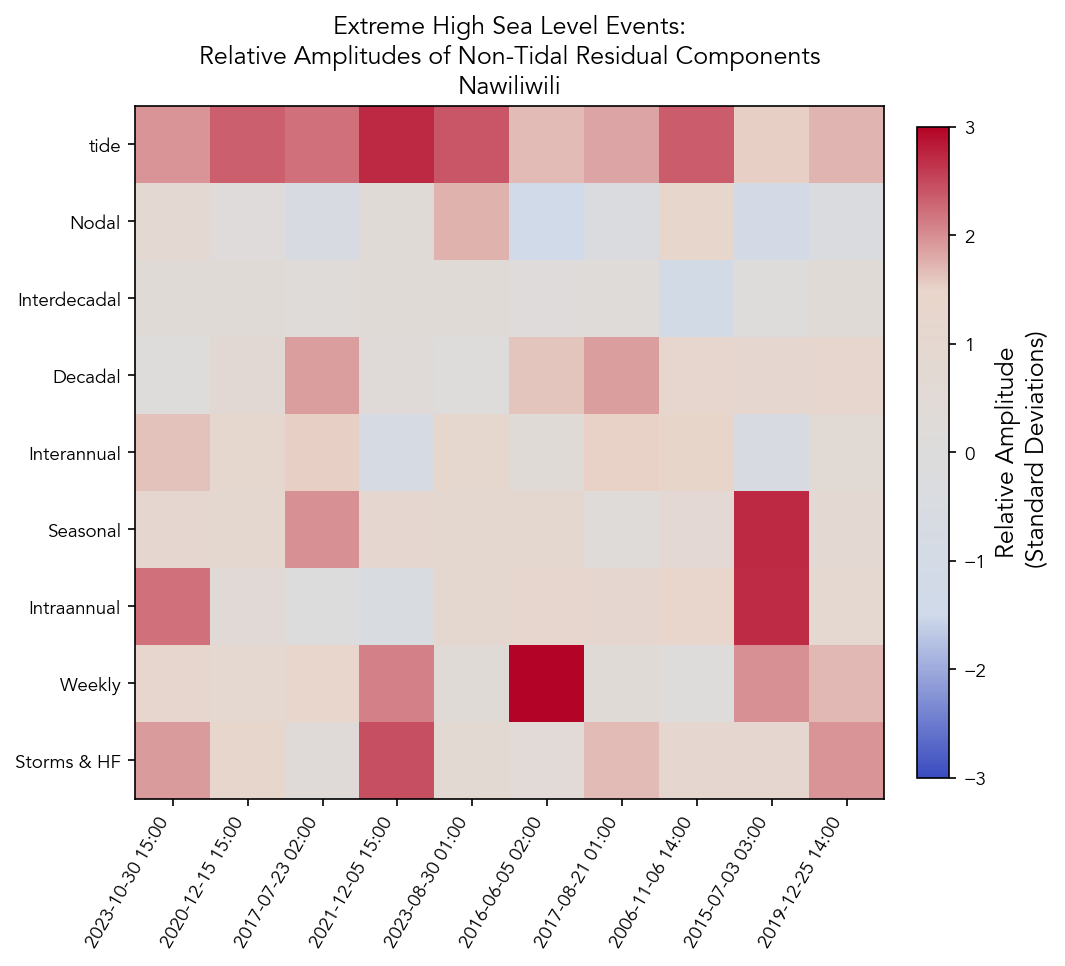

In [299]:
fig, ax = plot_component_amps(extremes_high_relative_to_std, high_or_low = 'high',station_name = station_name)
# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high.png'

print(output_path)
fig.savefig(output_path, bbox_inches='tight')